In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime as dt
import calendar
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
crime_data = pd.read_csv('Cleaned_df.csv')
crime_data.head()

,DR_NO,Date Rptd,Date Time OCC,AREA NAME,Rpt Dist No,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,...,Status,Status Desc,Crm Cd 1,LOCATION,LAT,LON,Weapon Used,Year,Month,Year_Month
0,10304468,2020-01-08,2020-01-08 22:30:00,Southwest,377,624,BATTERY - SIMPLE ASSAULT,36,F,B,...,AO,Adult Other,624.0,1100 W 39TH PL,34.0141,-118.2978,1,2020,1,2020-01
1,190101086,2020-01-02,2020-01-01 03:30:00,Central,163,624,BATTERY - SIMPLE ASSAULT,25,M,H,...,IC,Invest Cont,624.0,700 S HILL ST,34.0459,-118.2545,1,2020,1,2020-01
2,200110444,2020-04-14,2020-02-13 12:00:00,Central,155,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,0,X,X,...,AA,Adult Arrest,845.0,200 E 6TH ST,34.0448,-118.2474,0,2020,2,2020-02
3,191501505,2020-01-01,2020-01-01 17:30:00,N Hollywood,1543,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),76,F,W,...,IC,Invest Cont,745.0,5400 CORTEEN PL,34.1685,-118.4019,0,2020,1,2020-01
4,191921269,2020-01-01,2020-01-01 04:15:00,Mission,1998,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",31,X,X,...,IC,Invest Cont,740.0,14400 TITUS ST,34.2198,-118.4468,0,2020,1,2020-01


In [3]:
# Creating a copy of the crime data
df = crime_data.copy()

In [4]:
# Converting month-year column into the month year format
df['Date Time OCC'] = pd.to_datetime(df['Date Time OCC'])
df['month-year'] = df['Date Time OCC'].dt.strftime('%m-%Y')

In [5]:
# Grouping the crimes by month and year
df = df.groupby('month-year')['Crm Cd'].count()

In [6]:
# renaming columns and converting to appropriate data types
df_1 = df.to_frame().reset_index()
df_1 = df_1.rename(columns={'month-year':'Date','Crm Cd':'Crime'})
df_1['Date'] = pd.to_datetime(df_1['Date'])

# adding new column for number of days in month
df_1['days_in_month'] = df_1['Date'].dt.days_in_month
df_1.head()

,Date,Crime,days_in_month
0,2020-01-01,18473,31
1,2021-01-01,16525,31
2,2022-01-01,18424,31
3,2023-01-01,19548,31
4,2020-02-01,17252,29


In [7]:
# Normalising the number of crime by dividing it by number of days in respective months
df_1['Crime'] = round((df_1['Crime']/df_1['days_in_month']))
df_1.drop(columns=['days_in_month'],inplace=True)
df_1.head()

,Date,Crime
0,2020-01-01,596.0
1,2021-01-01,533.0
2,2022-01-01,594.0
3,2023-01-01,631.0
4,2020-02-01,595.0


In [8]:
# Sorting values of the dataframe based on date
df_1 = df_1.sort_values(by='Date').reset_index(drop=True) 

In [9]:
# reseting the Index of the Dataframe
df_1.set_index('Date',inplace=True)

In [10]:
df_1 = df_1[:-1]
df_1.shape

(44, 1)

# Seasonal ARIMA Time Series Forecasting

In [11]:
# Importing stats libraries  
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

In [12]:
# decomposing the data to analyse the trends, seasonality and residuals if any
result = seasonal_decompose(df_1['Crime'],model = 'additive',period = 12)

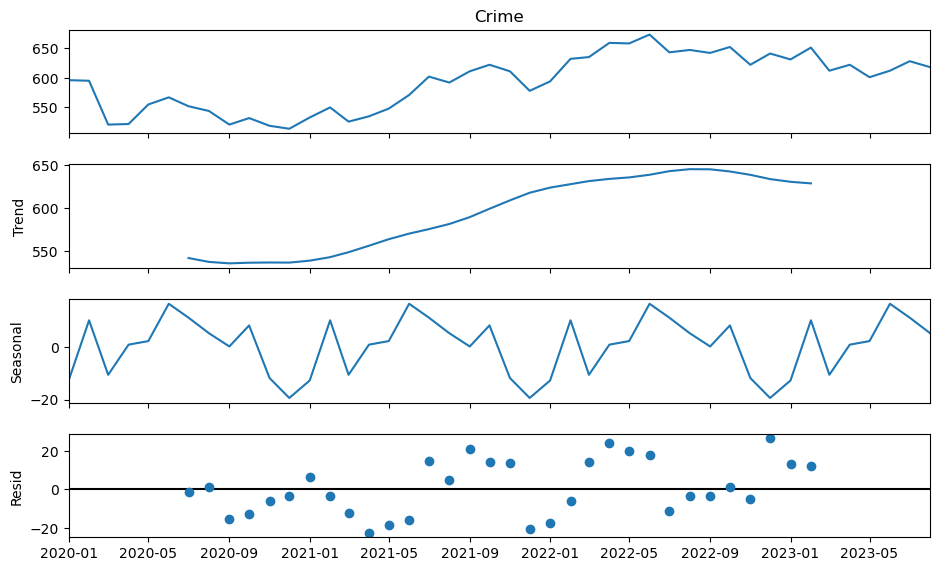

In [13]:
# visualising decomposition
ax = result.plot()
ax.set_size_inches(10,6)

1) The first subplot on the very top shows the plot for the original data with no decomposition. 2) The second subplot shows a clear smooth trend pattern in the data. This is clear evidence of a non-constant mean. 3) The third subplot shows the decomposed seasonality pattern in the data. 4) The last subplot shows the noise or residual component in the time series data

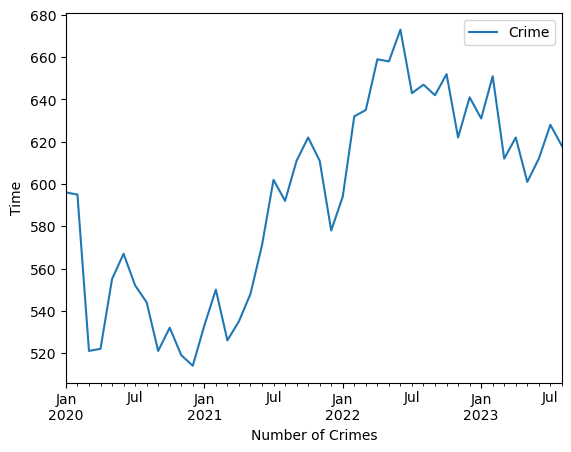

In [14]:
# Fluctuations in number of crime over time
df_1.plot()
plt.xlabel('Number of Crimes')
plt.ylabel('Time')
plt.show()

In [15]:
# Implementing the Augmented Dicky Fuller test to test the stationarity of data
ADF = adfuller(df_1['Crime'])

In [16]:
def ADF_CHECK(time_series):
    result = adfuller(time_series)
    print("Augmented Dicky-Fuller Test")
    labels = ["ADF Test statistic","p-value","# of lags","Num of observations used"]

    for val,lab in zip(result,labels):
        print(lab + ":" + str(val))
        
    alpha = 0.05   
    if result[1]<=alpha:
        print("Reject null hypothesis")
        print("Data does not have a unit root and is stationery")
    else:
        print("Fail to reject null hypothesis")
        print("Data has a unit root and it is non-stationery")


In [17]:
ADF_CHECK(df_1['Crime'])

Augmented Dicky-Fuller Test
ADF Test statistic:-1.4768186370337697
p-value:0.5449460798531898
# of lags:0
Num of observations used:43
Fail to reject null hypothesis
Data has a unit root and it is non-stationery


In [18]:
# difference the data and check for stationarity again
df_1["Difference_1"] = df_1['Crime']-df_1['Crime'].shift(1)
df_1.dropna(inplace=True)

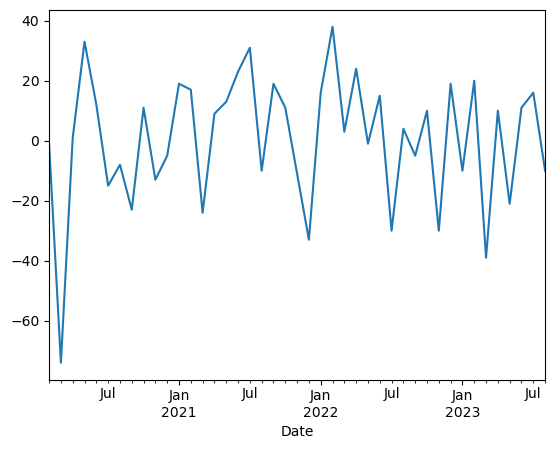

In [19]:
df_1["Difference_1"].plot()
plt.show();

In [20]:
ADF_CHECK(df_1["Difference_1"])

Augmented Dicky-Fuller Test
ADF Test statistic:-7.094152425938138
p-value:4.332824012200676e-10
# of lags:0
Num of observations used:42
Reject null hypothesis
Data does not have a unit root and is stationery


**Data is Stationary now**

<Axes: xlabel='Date'>

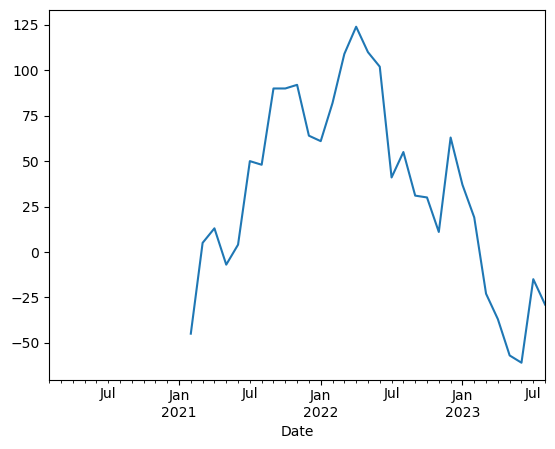

In [21]:
df_1["Seasonal Difference"] = df_1['Crime']-df_1['Crime'].shift(12)
df_1["Seasonal Difference"].plot()

We will look at the Autocorrelation function (ACF) plot and the Partial Autocorrelation Function (PACF) plots to get get a sense of which lags are significant.

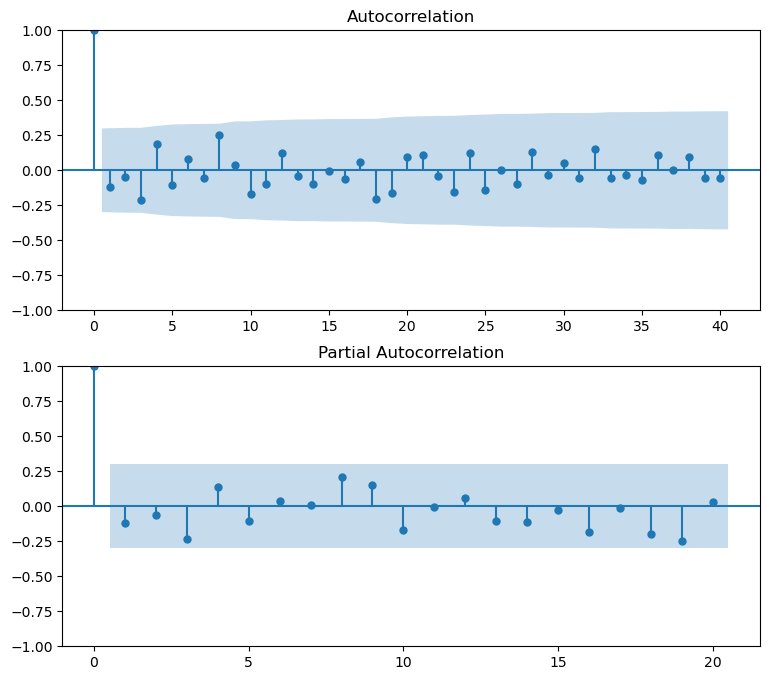

In [22]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(9,8))

ACF = plot_acf(df_1["Difference_1"],lags=40, alpha=0.05, ax=ax1)
PACF = plot_pacf(df_1["Difference_1"],lags=20,alpha=0.05,ax=ax2)
plt.show()

"When data have a trend, the autocorrelations for small lags tend to be large and positive because observations nearby in time are also nearby in size. So the ACF of trended time series tend to have positive values that slowly decrease as the lags increase. When data are seasonal, the autocorrelations will be larger for the seasonal lags (at multiples of the seasonal frequency) than for other lags." -- https://otexts.com/fpp2/autocorrelation.html


Implementing the Seasonal ARIMA time series model to forecast the future crimes.

In [23]:
SARIMA_model = SARIMAX(df_1['Crime'],order = (1,1,1),seasonal_order = (1,1,1,12))

In [24]:
result = SARIMA_model.fit(disp=0)

In [25]:
# results
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Crime   No. Observations:                   43
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -137.846
Date:                            Mon, 06 Nov 2023   AIC                            285.692
Time:                                    23:29:37   BIC                            292.698
Sample:                                02-01-2020   HQIC                           287.934
                                     - 08-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8471      0.995     -0.852      0.394      -2.797       1.102
ma.L1          0.7741      1.132   

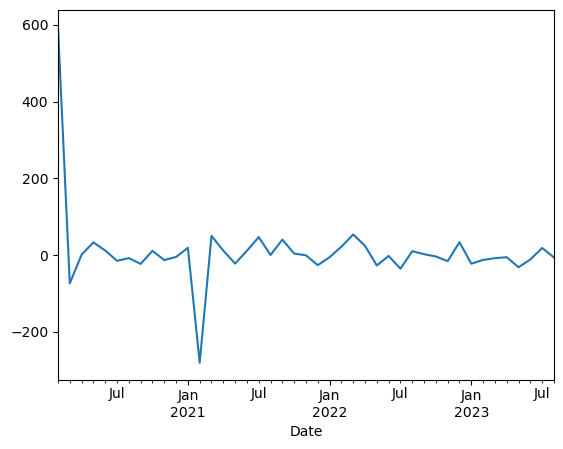

In [26]:
# graphical representation of residuals (goodness of fit)
result.resid.plot()
plt.show();

**Backtesting - Visualising how the model is performing over the past data**

<Axes: xlabel='Date'>

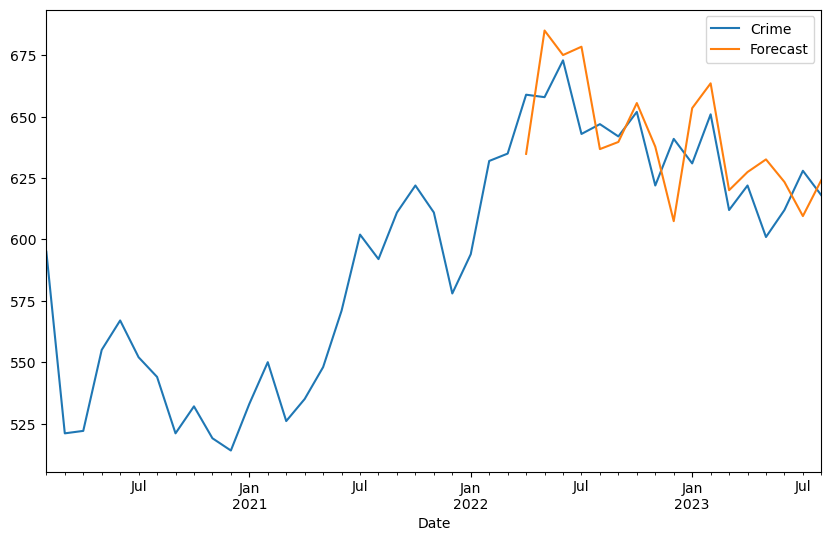

In [27]:
predicted = result.predict(start=17, end=44)
df_1["Forecast"] = result.predict(start=26, end=44)
df_1[["Crime","Forecast"]].plot(figsize = (10,6))
#Orange one is the one predicted by the sarima model

As we can see, the model fits really well for the past data

### Generating the future dates in order to forecast the number of crimes in future

In [28]:
from pandas.tseries.offsets import DateOffset

In [29]:
future_dates = [df_1.index[-1] + DateOffset(months = x) for x in range(1,10)]

future_data = pd.DataFrame(index = future_dates,columns = df_1.columns)

final_data = pd.concat([df_1,future_data])
final_data.head()

,Crime,Difference_1,Seasonal Difference,Forecast
2020-02-01,595.0,-1.0,NaN,NaN
2020-03-01,521.0,-74.0,NaN,NaN
2020-04-01,522.0,1.0,NaN,NaN
2020-05-01,555.0,33.0,NaN,NaN
2020-06-01,567.0,12.0,NaN,NaN


In [30]:
# forecasting
final_data["Forecast"] = result.predict(start = 42,end = 57)
final_data["Forecast"][44]

629.9570444430585

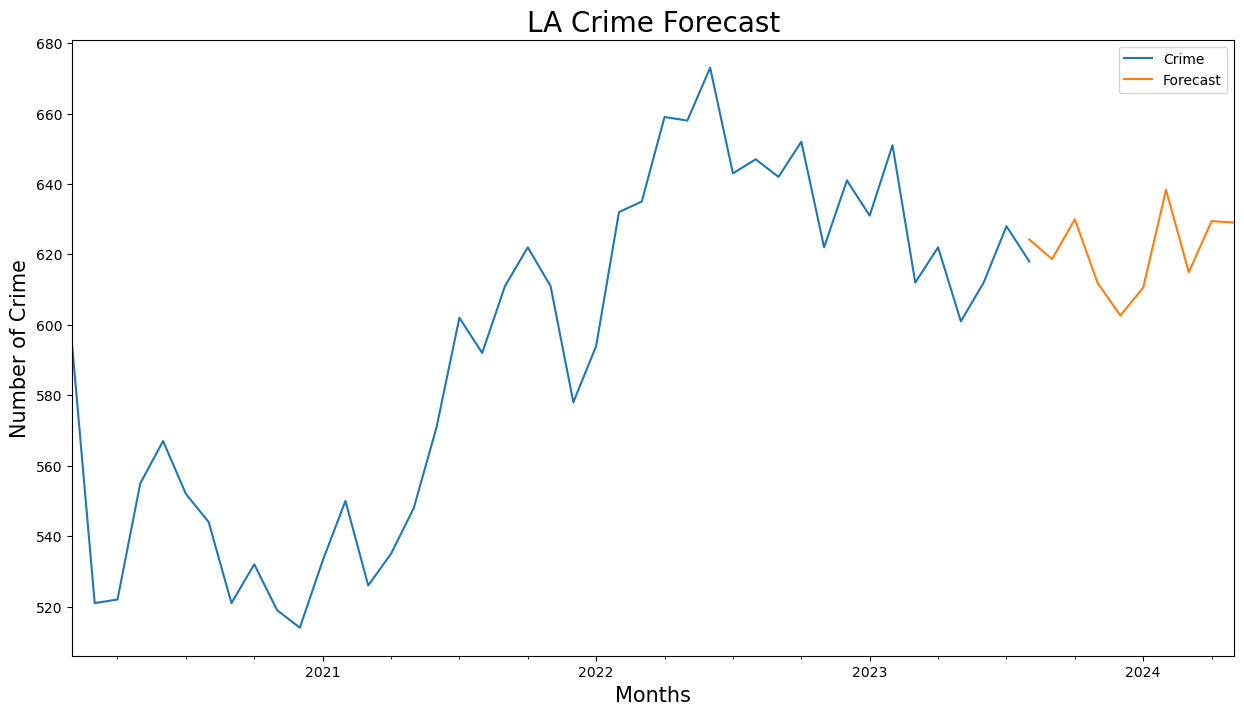

In [31]:
# visualising the number of crimes, that are forecasted by our model
final_data["Crime"].plot()
final_data["Forecast"].plot(figsize = (15,8))
plt.title("LA Crime Forecast",size = 20)
plt.xlabel("Months",size=15)
plt.ylabel("Number of Crime",size=15)
plt.legend();

In [32]:
from sklearn.metrics import mean_squared_error
from math import sqrt
 
actual = df_1['Crime'][17:-1]
predicted = predicted[:-3]

rmse = sqrt(mean_squared_error(actual,predicted))
print('RMSE of SARIMA model:',round(rmse,2))

RMSE of SARIMA model: 23.84


# Prophet time series forecasting

In [33]:
from prophet import Prophet

In [34]:
df = crime_data.copy()

In [35]:
df['Date Time OCC'] = pd.to_datetime(df['Date Time OCC'])
df['month-year'] = df['Date Time OCC'].dt.strftime('%m-%Y')
df = df.groupby('month-year')['Crm Cd'].count()

In [36]:
df_2 = df.to_frame().reset_index()
df_2 = df_2.rename(columns={'month-year':'Date','Crm Cd':'Crime'})
df_2['Date'] = pd.to_datetime(df_2['Date'])
df_2['days_in_month'] = df_2['Date'].dt.days_in_month
df_2.head()

,Date,Crime,days_in_month
0,2020-01-01,18473,31
1,2021-01-01,16525,31
2,2022-01-01,18424,31
3,2023-01-01,19548,31
4,2020-02-01,17252,29


In [37]:
df_2['Crime'] = round((df_2['Crime']/df_2['days_in_month']))
df_2.drop(columns=['days_in_month'],inplace=True)
df_2.tail()

,Date,Crime
40,2021-11-01,611.0
41,2022-11-01,622.0
42,2020-12-01,514.0
43,2021-12-01,578.0
44,2022-12-01,641.0


In [38]:
df_2 = df_2.sort_values(by='Date').reset_index(drop=True)
df_2.set_index('Date',inplace=True)

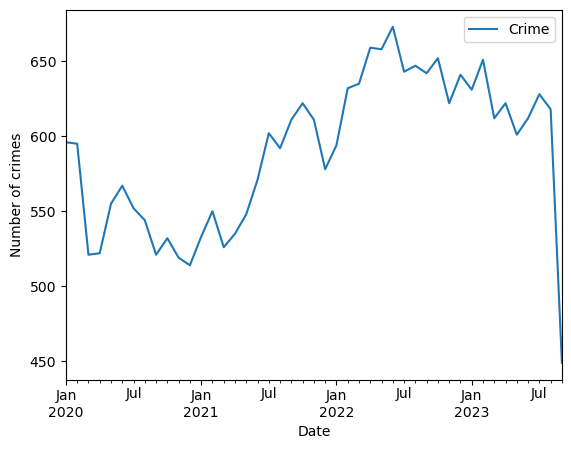

In [39]:
df_2.plot()
plt.ylabel('Number of crimes');

In [40]:
df_2.reset_index(inplace=True)
df_2.rename(columns={'Date':'ds','Crime':'y'},inplace=True)

In [41]:
# Implementing Prophet time series forecasting
model = Prophet()
model.fit(df_2)

23:29:40 - cmdstanpy - INFO - Chain [1] start processing
23:29:40 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
# generating the future dates
future_date = model.make_future_dataframe(periods=10,freq='m')

In [43]:
# predicting for future dates
prediction = model.predict(future_date)

<Figure size 600x400 with 0 Axes>

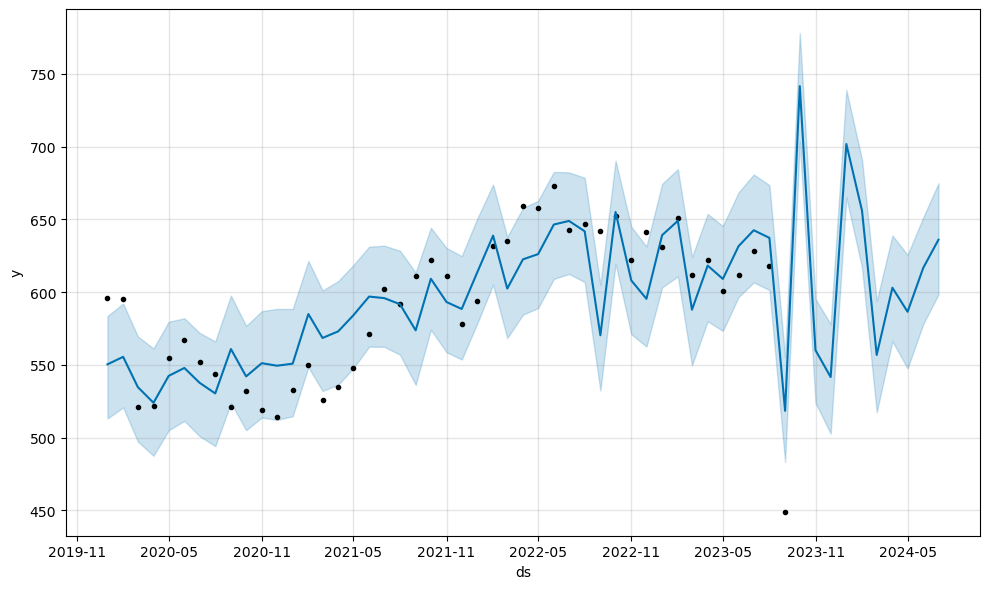

In [44]:
# visualising the predicted number of crime
plt.figure(figsize=(6,4))
model.plot(prediction)
plt.show();

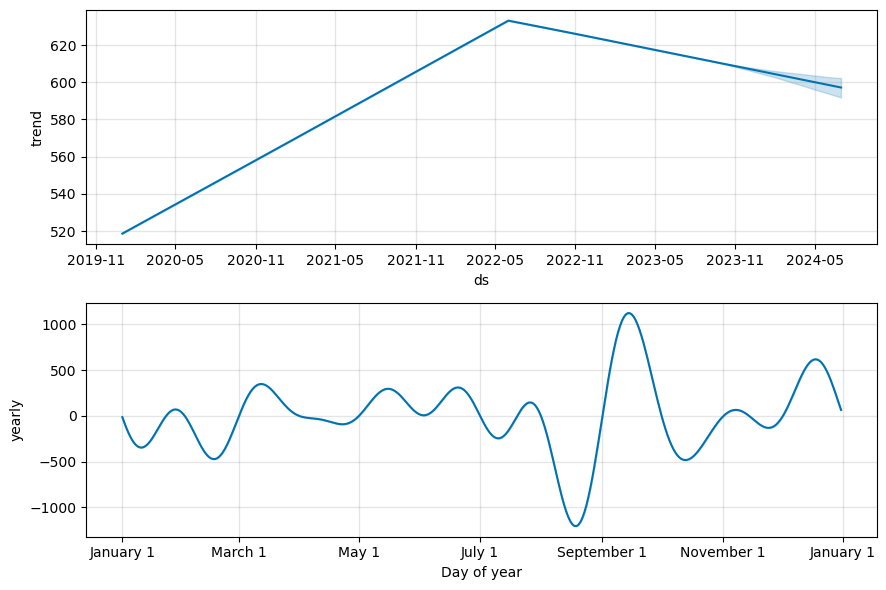

In [45]:
# plotting predicted components
model.plot_components(prediction)
plt.show()

In [46]:
from prophet.diagnostics import cross_validation, performance_metrics

In [47]:
# Perform cross-validation with initial 365 days for the first training data and the cut-off for every 180 days.
cutoffs = pd.date_range(start='2020-02-01', end='2022-12-01', freq='1MS')
df_cv = cross_validation(model, horizon='90 days', cutoffs=cutoffs)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/35 [00:00<?, ?it/s]

23:29:40 - cmdstanpy - INFO - Chain [1] start processing
23:29:41 - cmdstanpy - INFO - Chain [1] done processing
23:29:41 - cmdstanpy - INFO - Chain [1] start processing
23:29:41 - cmdstanpy - INFO - Chain [1] done processing
23:29:41 - cmdstanpy - INFO - Chain [1] start processing
23:29:41 - cmdstanpy - INFO - Chain [1] done processing
23:29:41 - cmdstanpy - INFO - Chain [1] start processing
23:29:41 - cmdstanpy - INFO - Chain [1] done processing
23:29:41 - cmdstanpy - INFO - Chain [1] start processing
23:29:41 - cmdstanpy - INFO - Chain [1] done processing
23:29:41 - cmdstanpy - INFO - Chain [1] start processing
23:29:43 - cmdstanpy - INFO - Chain [1] done processing
23:29:43 - cmdstanpy - INFO - Chain [1] start processing
23:29:43 - cmdstanpy - INFO - Chain [1] done processing
23:29:43 - cmdstanpy - INFO - Chain [1] start processing
23:29:47 - cmdstanpy - INFO - Chain [1] done processing
23:29:47 - cmdstanpy - INFO - Chain [1] start processing
23:29:47 - cmdstanpy - INFO - Chain [1]

In [48]:
# Calculate evaluation metrics
res = performance_metrics(df_cv)
res

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,6.024793e+07,7761.954022,2874.054895,5.522660,0.133480,0.624363,0.0
1,31 days,1.137902e+07,3373.279876,1586.868098,2.904921,0.137641,0.629735,0.0
2,59 days,4.945284e+06,2223.799525,805.313447,1.479315,0.796189,0.428217,0.0
3,60 days,4.099586e+06,2024.743471,912.400584,1.703757,0.796189,0.535731,0.0
4,61 days,1.033630e+07,3215.011466,1560.173643,2.943175,0.188097,0.776290,0.0
5,62 days,2.186576e+06,1478.707444,667.602638,1.250737,0.111741,0.632595,0.0
6,89 days,5.993151e+05,774.154463,411.207334,0.763372,0.111741,0.496947,0.0
7,90 days,4.711529e+06,2170.605720,919.051664,1.656187,0.091759,0.447047,0.0


In [49]:
from prophet.plot import plot_cross_validation_metric
#choose between 'mse', 'rmse', 'mae', 'mape', 'coverage'

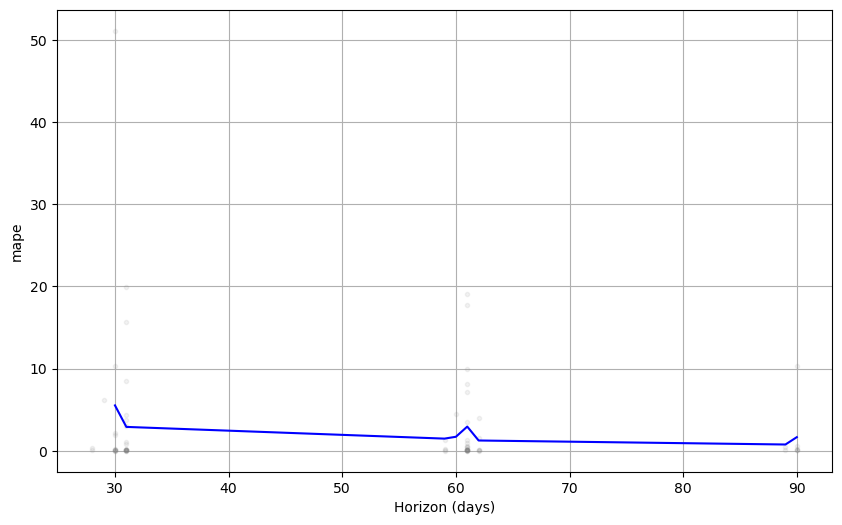

In [50]:
plot_cross_validation_metric(df_cv, metric= 'mape')
plt.show()